In [ ]:

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

DATA_PROCESSED = "../data/processed"

# Load train/test data
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"))

# Define outcome variable 
target = "approved"

# Excluded unnecessary columns
drop_cols = ["approved", "lei", "action_taken", "state_code", "county_code", "census_tract"]

X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
y_train = train[target]

X_test = test.drop(columns=[c for c in drop_cols if c in test.columns])
y_test = test[target]

# Keep only numeric columns for regression
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Replace inf with NaN
X_train_num = X_train[num_cols].replace([np.inf, -np.inf], np.nan)
X_test_num = X_test[num_cols].replace([np.inf, -np.inf], np.nan)

# Drop all-NaN columns
nan_cols = X_train_num.columns[X_train_num.isna().all()].tolist()
if nan_cols:
    print("Dropping all-NaN columns:", nan_cols)
    X_train_num = X_train_num.drop(columns=nan_cols)
    X_test_num = X_test_num.drop(columns=nan_cols)
    num_cols = X_train_num.columns.tolist()

# Force numeric coercion to handle mixed-type columns like "5-24"
X_train_num = X_train_num.apply(pd.to_numeric, errors="coerce")
X_test_num = X_test_num.apply(pd.to_numeric, errors="coerce")

# Fill remaining NaNs with median
imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(imputer.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_test_num = pd.DataFrame(imputer.transform(X_test_num), columns=num_cols, index=X_test.index)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Logistic Regression Baseline (original) 
clf = LogisticRegression(max_iter=1000, solver="liblinear")
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print("=== Original Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Logistic Regression with Class Weighting
clf_bal = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf_bal.fit(X_train_scaled, y_train)

y_pred_bal = clf_bal.predict(X_test_scaled)
y_prob_bal = clf_bal.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression (Balanced) ===")
print(classification_report(y_test, y_pred_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_bal))

# Compare two models
coefs = pd.Series(clf.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)
coefs_bal = pd.Series(clf_bal.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)

print("\nTop coefficients (Original):")
print(coefs.head(15))

print("\nTop coefficients (Balanced):")
print(coefs_bal.head(15))

# --- Plot Coefficient Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

coefs.head(15).plot(kind="barh", ax=axes[0], title="Original Logistic Regression")
coefs_bal.head(15).plot(kind="barh", ax=axes[1], title="Balanced Logistic Regression")

plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

DATA_PROCESSED = "../data/processed"

# Load data
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"))

target = "approved"

# Define leaky variables
LEAKAGE_VARS = [
    "approved",                     
    "denial_reason_1", "denial_reason-1",   
    "hoepa_status",
    "origination_charges",
    "preapproval",
    "rate_spread",
    "total_points_and_fees",
    "total_loan_costs",
    "lender_credits",
    "initially_payable_to_institution",
    "discount_points",
    "interest_only_payment",
    "negative_amortization",
    "balloon_payment",
    "other_nonamortizing_features",
    "intro_rate_period"
]

drop_cols = ["lei", "action_taken", "state_code", "county_code", "census_tract"] + LEAKAGE_VARS

X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
y_train = train[target]
X_test = test.drop(columns=[c for c in drop_cols if c in test.columns])
y_test = test[target]

# Keep only numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Handle NaNs
X_train_num = X_train[num_cols].replace([np.inf, -np.inf], np.nan)
X_test_num = X_test[num_cols].replace([np.inf, -np.inf], np.nan)

# Drop all-NaN cols
X_train_num = X_train_num.dropna(axis=1, how="all")
X_test_num = X_test_num[X_train_num.columns]

# Coerce non-numeric entries to NaN before imputation
X_train_num = X_train[num_cols].apply(pd.to_numeric, errors="coerce")
X_test_num = X_test[num_cols].apply(pd.to_numeric, errors="coerce")

# Replace inf/-inf with NaN (just in case)
X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan)
X_test_num = X_test_num.replace([np.inf, -np.inf], np.nan)

# Drop all-NaN columns
X_train_num = X_train_num.dropna(axis=1, how="all")
X_test_num = X_test_num[X_train_num.columns]

# Impute + scale
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train_num))
X_test_scaled = scaler.transform(imputer.transform(X_test_num))

# Fit logistic regression
clf = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print("=== Fairness-Ready Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Examine coefficients
coefs = pd.Series(clf.coef_[0], index=X_train_num.columns).sort_values(key=abs, ascending=False)
print("\nTop 15 coefficients (no leakage):")
print(coefs.head(15))

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_91501/2823635689.py:13: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"))


=== Fairness-Ready Logistic Regression ===
              precision    recall  f1-score   support

           0       0.18      0.66      0.28      7204
           1       0.95      0.69      0.80     71697

    accuracy                           0.69     78901
   macro avg       0.57      0.68      0.54     78901
weighted avg       0.88      0.69      0.76     78901

ROC-AUC: 0.7434149974114103

Top 15 coefficients (no leakage):
aus-1                             -1.633083
co-applicant_sex_observed          0.851912
co-applicant_race_observed        -0.825273
dti_clean                         -0.687604
submission_of_application         -0.231140
income_ratio                      -0.203349
interest_rate                     -0.148577
loan_amount                       -0.119034
construction_method               -0.113329
co-applicant_ethnicity_observed   -0.113263
tract_owner_occupied_units         0.105585
log_income                         0.102936
loan_term                          0.09

In [4]:
from sklearn.metrics import confusion_matrix

# Add back race_group labels from test set
test_with_preds = test.copy()
test_with_preds["y_pred"] = y_pred  # your balanced model's predictions
test_with_preds["y_prob"] = y_prob

# Compute approval rates
approval_rates = test_with_preds.groupby("race_group_original")["y_pred"].mean()
print("\nApproval Rates by Race Group:\n", approval_rates)

# Disparate Impact (relative to White)
white_rate = approval_rates.get("White", np.nan)
di_ratios = approval_rates / white_rate
print("\nDisparate Impact Ratios (vs White):\n", di_ratios)

# Error rates (False Negative Rate and False Positive Rate)
print("\nError Rates by Race Group:")
for group, subset in test_with_preds.groupby("race_group_original"):
    tn, fp, fn, tp = confusion_matrix(subset["approved"], subset["y_pred"]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"{group}: FNR={fnr:.3f}, FPR={fpr:.3f}")


Approval Rates by Race Group:
 race_group_original
American Indian or Alaska Native    0.703557
Asian                               0.655404
Black or African American           0.559433
Hispanic or Latino                  0.618340
Pacific Islander                    0.597884
White                               0.679526
Name: y_pred, dtype: float64

Disparate Impact Ratios (vs White):
 race_group_original
American Indian or Alaska Native    1.035365
Asian                               0.964501
Black or African American           0.823270
Hispanic or Latino                  0.909959
Pacific Islander                    0.879854
White                               1.000000
Name: y_pred, dtype: float64

Error Rates by Race Group:
American Indian or Alaska Native: FNR=0.244, FPR=0.389
Asian: FNR=0.313, FPR=0.357
Black or African American: FNR=0.395, FPR=0.274
Hispanic or Latino: FNR=0.353, FPR=0.370
Pacific Islander: FNR=0.339, FPR=0.095
White: FNR=0.290, FPR=0.341


In [9]:
train[train["race_group_original"] == "American Indian or Alaska Native"][["income_ratio", "loan_to_value_ratio", "dti_clean"]].isna().mean()

income_ratio           0.0
loan_to_value_ratio    0.0
dti_clean              0.0
dtype: float64

In [ ]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data 
DATA_PROCESSED = "../data/processed"
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))

# Define features 
controls = [
    "income_ratio",
    "loan_to_value_ratio",
    "dti_clean",
]

race_vars = [
    "race_group_Black or African American",
    "race_group_Hispanic or Latino",
    "race_group_Asian",
    "race_group_Pacific Islander",
    "race_group_American Indian or Alaska Native",
]

features = controls + race_vars

# Prepare function (robust numeric conversion)
def prepare_for_logit(df, features, target="approved"):
    available = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    if missing:
        print(f"⚠️ Missing {len(missing)} feature(s): {missing}")

    # Extract and coerce to numeric
    X = df[available].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.astype(float)

    # Drop NaNs
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = df.loc[valid_idx, target].astype(float)

    # Add constant (intercept)
    X = sm.add_constant(X)
    print(f"✅ Final X shape: {X.shape}, y shape: {y.shape}")
    print(f"✅ Dtypes:\n{X.dtypes.value_counts()}")

    return X, y

# Prepare and fit model 
X, y = prepare_for_logit(train, features)
model = sm.Logit(y, X).fit(disp=True)
print(model.summary())

# Compute odds ratios 
odds_ratios = pd.DataFrame({
    "Variable": model.params.index,
    "Coefficient": model.params.values,
    "OddsRatio": np.exp(model.params.values),
    "P>|z|": model.pvalues.values,
    "Conf. Interval (lower)": np.exp(model.conf_int()[0]),
    "Conf. Interval (upper)": np.exp(model.conf_int()[1]),
})

odds_ratios = odds_ratios.reindex(
    odds_ratios["Coefficient"].abs().sort_values(ascending=False).index
)

print("\n=== Odds Ratios (sorted by magnitude) ===")
print(odds_ratios.round(4))

odds_ratios.to_csv("../data/processed/fairness_logit_odds_ratios.csv", index=False)
print("\n✅ Model results saved to ../data/processed/fairness_logit_odds_ratios.csv")

⚠️ Missing 1 feature(s): ['race_group_American Indian or Alaska Native']
✅ Final X shape: (183712, 8), y shape: (183712,)
✅ Dtypes:
float64    8
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.273979
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               183712
Model:                          Logit   Df Residuals:                   183704
Method:                           MLE   Df Model:                            7
Date:                Sat, 11 Oct 2025   Pseudo R-squ.:                  0.1015
Time:                        18:14:26   Log-Likelihood:                -50333.
converged:                       True   LL-Null:                       -56018.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025   

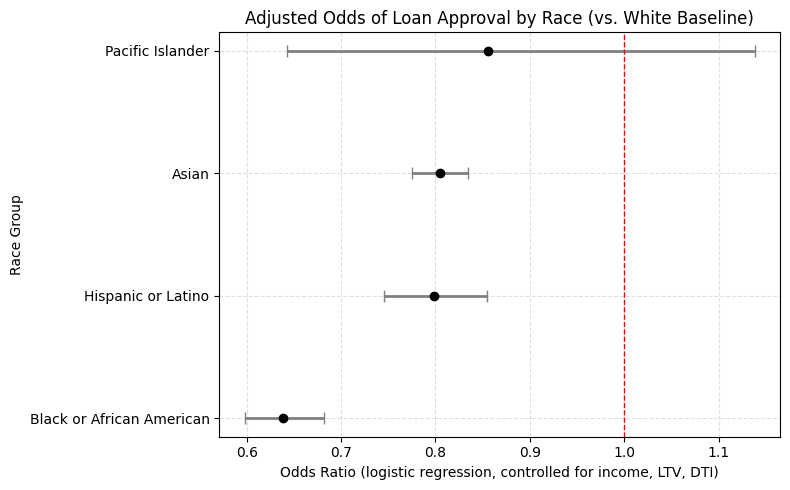

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for race-related variables only
race_vars = odds_ratios[odds_ratios["Variable"].str.contains("race_group")].copy()

# Sort by odds ratio (ascending)
race_vars = race_vars.sort_values("OddsRatio")

# Plot 
plt.figure(figsize=(8, 5))
plt.errorbar(
    race_vars["OddsRatio"],
    race_vars["Variable"].str.replace("race_group_", ""),
    xerr=[
        race_vars["OddsRatio"] - race_vars["Conf. Interval (lower)"],
        race_vars["Conf. Interval (upper)"] - race_vars["OddsRatio"],
    ],
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=2,
    capsize=4,
)

# Reference line (White = 1.0 baseline)
plt.axvline(x=1, color="red", linestyle="--", linewidth=1)
plt.title("Adjusted Odds of Loan Approval by Race (vs. White Baseline)")
plt.xlabel("Odds Ratio (logistic regression, controlled for income, LTV, DTI)")
plt.ylabel("Race Group")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()